
<center><b>Data Dictionary:</b> https://docs.google.com/document/d/1aYqMaddLpN0Skgwa17HRg-jwqOZ0NVLyWd1-zyTXGro/edit?usp=sharing</center><br><br>

## 1. GET/IMPORT THE DATA

In [1]:
#load libraries and data
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile
import seaborn as sns
from pandas.plotting import scatter_matrix


ow = pd.read_csv('assets/overwatch-diary.csv', index_col = 0)

In [2]:
ow.head()

,result,game_id,sr_start,sr_finish,sr_change,streak_number,my_team_sr,enemy_team_sr,map,round,...,character_1,character_2,character_3,eliminations,objective_kills,healing,deaths,weapon_accuracy,offensive_assists,defensive_assists
season,,,,,,,,,,,,,,,,,,,,,
3,W,203.0,NaN,NaN,0,NaN,2929.0,2922.0,Dorado,4.0,...,1_Zenyatta,2_na,3_na,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,W,11.0,NaN,NaN,0,2.0,NaN,NaN,Dorado,2.0,...,1_Zenyatta,2_na,3_na,12.0,7.0,3791.0,4517.0,2.0,20.0,7.0
4,W,NaN,NaN,NaN,0,1.0,2649.0,2638.0,Dorado,4.0,...,1_Zenyatta,2_na,3_na,17.0,14.0,10022.0,6940.0,7.0,31.0,9.0
4,W,NaN,NaN,NaN,0,5.0,2895.0,2892.0,Dorado,2.0,...,1_Zenyatta,2_na,3_na,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,W,150.0,NaN,NaN,0,NaN,2992.0,2921.0,Dorado,3.0,...,1_Zenyatta,2_na,3_na,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#create dummy variable for each object features
#based on rexexp analysis in project 4, we will not include 'psychological_conditon'
result_dummy = pd.get_dummies(ow['result'])
map_dummy = pd.get_dummies(ow['map'])
role_dummy = pd.get_dummies(ow['team_role'])
hero1_dummy = pd.get_dummies(ow['character_1'])
hero2_dummy = pd.get_dummies(ow['character_2'])
hero3_dummy = pd.get_dummies(ow['character_3'])

#concetenate dummies into ow
ow_dummy = pd.concat([ow, result_dummy, map_dummy, role_dummy, hero1_dummy, hero2_dummy, hero3_dummy], axis = 1)

In [4]:
#drop object features so all features are float
ow_dummy = ow_dummy.drop(columns=['result','map','team_role','character_1','character_2','character_3'])
ow_dummy.dtypes

game_id              float64
sr_start             float64
sr_finish            float64
sr_change              int64
streak_number        float64
my_team_sr           float64
enemy_team_sr        float64
round                float64
capscore             float64
score_distance       float64
match_length         float64
eliminations         float64
objective_kills      float64
healing              float64
deaths               float64
weapon_accuracy      float64
offensive_assists    float64
defensive_assists    float64
L                      uint8
W                      uint8
Dorado                 uint8
Eichenwalde            uint8
Gibraltar              uint8
Hanamura               uint8
Hollywood              uint8
Horizon                uint8
Ilios                  uint8
Junkertown             uint8
King's Row             uint8
Lijiang Tower          uint8
                      ...   
1_Zarya                uint8
1_Zenyatta             uint8
1_Zenyatta             uint8
1_torbjorn    

## 2. TEST/TRAIN/SPLIT AND SCALE

In [5]:
#Now that we have all of dummy variables and have removed objects, let's instatitate
#The new 'W' Column will be what we're trying to predict because a '1' will mean a win and '0' will be a loss.
X = ow_dummy.drop(['W'], axis=1)
y = ow_dummy['W']

In [6]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

## 3. EDA OF TRAIN DATA
Note: Here are some things to consider in your notebook: sample size, correlations, feature importance, unexplained variance or outliers, variable selection, train/test comparison, and any relationships between your target and independent variables.

In [7]:
# let's fill nulls with the feature median
X_train.fillna(ow.median(),inplace=True)
X_train.describe()

/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,game_id,sr_start,sr_finish,sr_change,streak_number,my_team_sr,enemy_team_sr,round,capscore,score_distance,...,2_na,3_Ana,3_Lucio,3_Mercy,3_Soldier,3_Symmetra,3_Zarya,3_Zenyatta,3_lucio,3_na
count,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000,...,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000
mean,168.356900,2561.074858,2561.798110,0.472590,2.103592,2652.848771,2652.824953,1.948582,1.618147,72.218242,...,0.841210,0.004159,0.003781,0.004537,0.000378,0.000378,0.000378,0.003403,0.000756,0.982231
std,120.603234,146.839177,146.381587,101.423759,1.403693,220.719026,223.103425,0.981487,1.016566,85.076266,...,0.365549,0.064367,0.061383,0.067216,0.019444,0.019444,0.019444,0.058244,0.027493,0.132137
min,1.000000,1966.000000,1966.000000,-2654.000000,1.000000,1964.000000,1937.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,91.000000,2573.000000,2573.500000,0.000000,1.000000,2534.000000,2530.000000,1.000000,1.000000,71.750000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,144.500000,2573.000000,2573.500000,0.000000,2.000000,2655.000000,2656.000000,2.000000,2.000000,71.750000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,199.000000,2573.000000,2574.000000,0.000000,2.000000,2809.000000,2808.000000,2.000000,2.000000,71.750000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,538.000000,3017.000000,3008.000000,2698.000000,13.000000,3178.000000,3172.000000,6.000000,4.000000,4375.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<IPython.core.display.Javascript object>


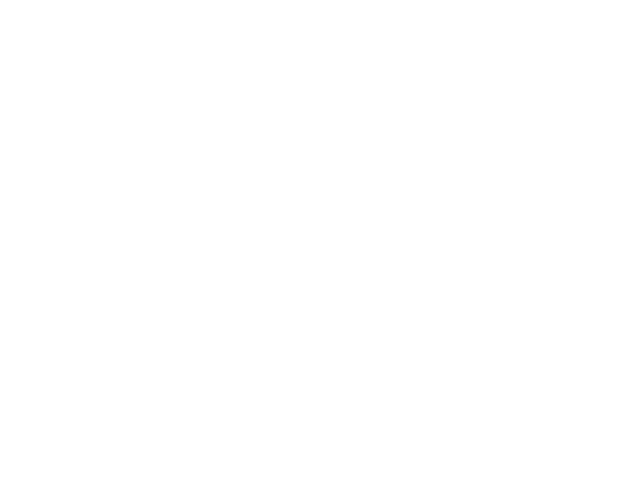

In [8]:
sns.heatmap(X_train.isnull().replace({True: 1, False: 0}));

<IPython.core.display.Javascript object>


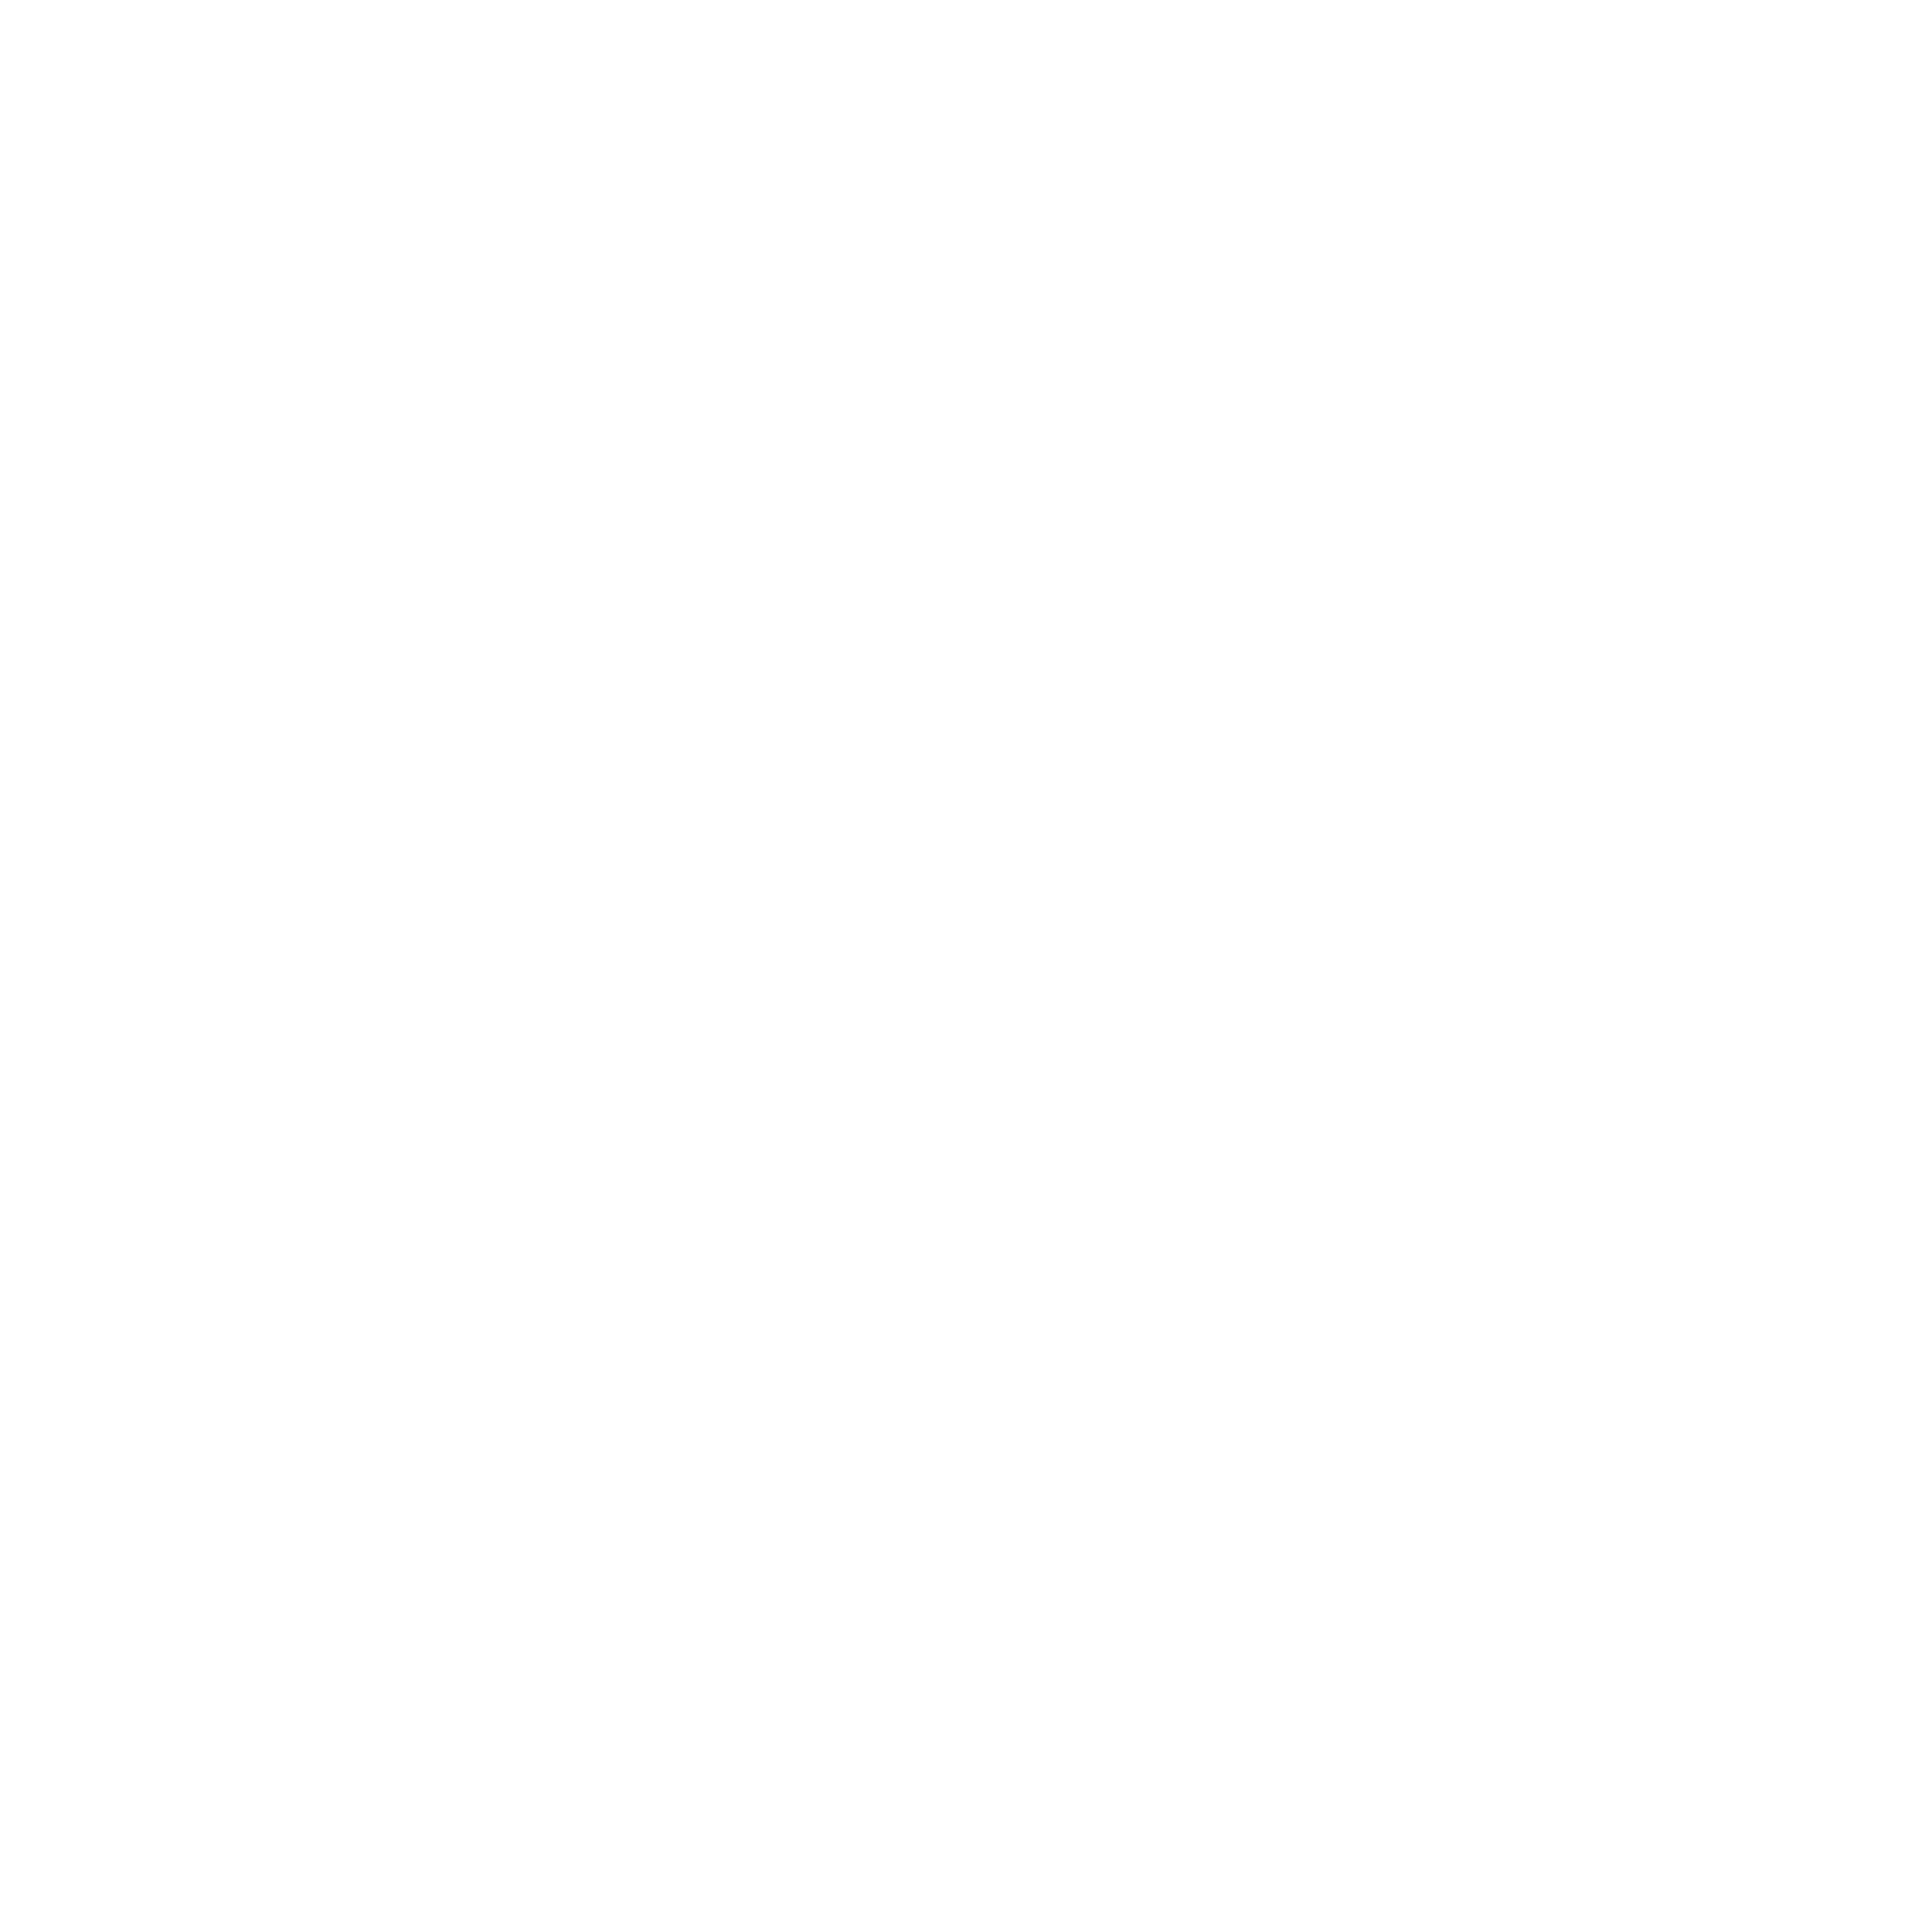

<IPython.core.display.Javascript object>


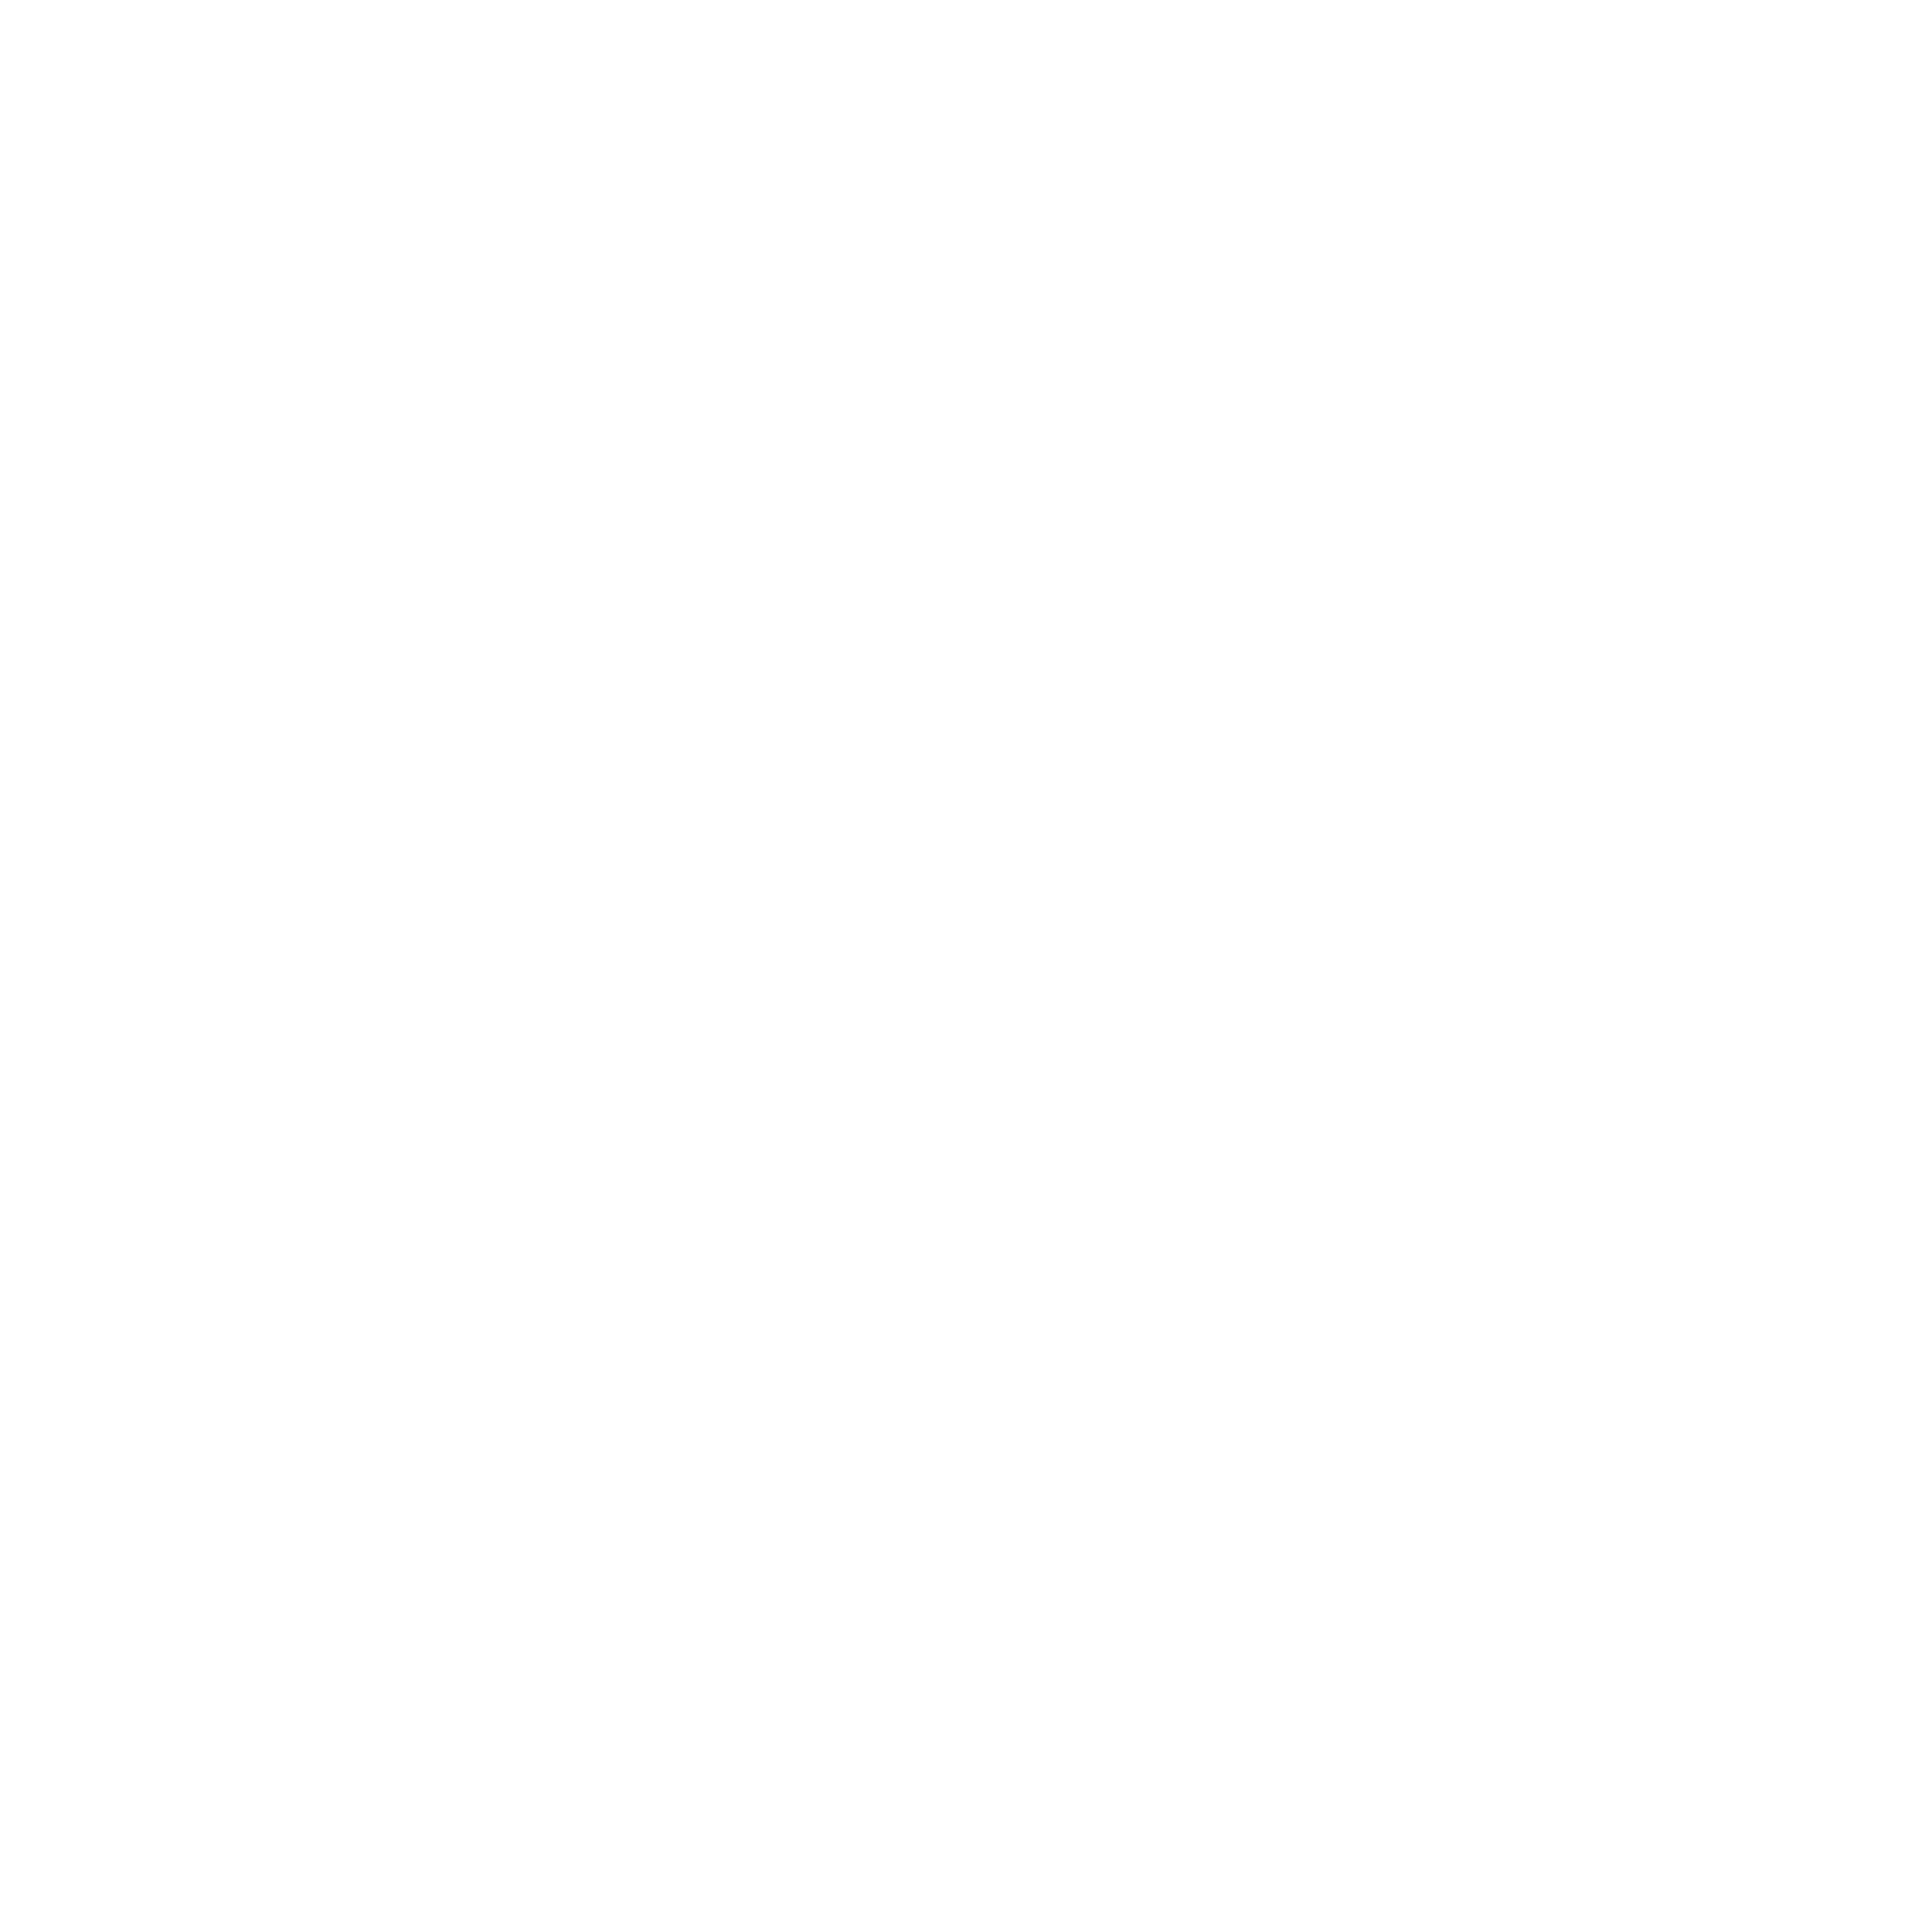

W
0    [[AxesSubplot(0.125,0.81937;0.0679825x0.060629...
1    [[AxesSubplot(0.125,0.81937;0.0679825x0.060629...
dtype: object

In [9]:
#check distribution (histogram)
X_train.groupby(y_train).hist(figsize=(20,20))


<IPython.core.display.Javascript object>


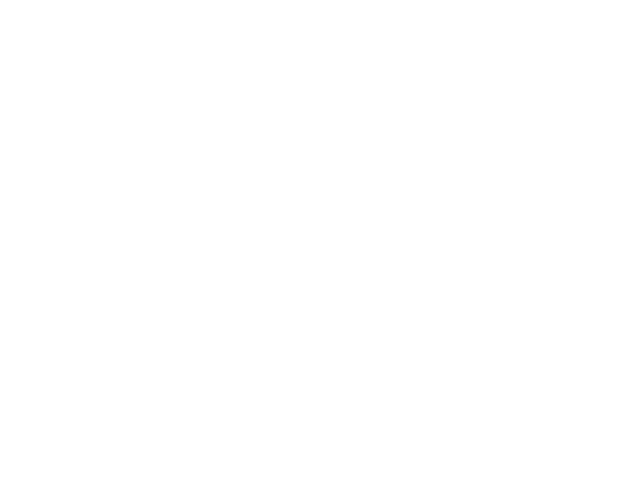

In [10]:
#outliers boxplot
X_train.plot(kind='box')

In [11]:
#correlation matrix
X_train.corr

<bound method DataFrame.corr of         game_id  sr_start  sr_finish  sr_change  streak_number  my_team_sr  \
season                                                                       
4         144.5    2754.0     2735.0        -19            1.0      2748.0   
4         144.5    2771.0     2796.0         25            2.0      2788.0   
3         157.0    2452.0     2414.0        -38            2.0      2913.0   
3         281.0    2573.0     2573.5          0            2.0      2479.0   
6         207.0    2573.0     2573.5          0            1.0      3070.0   
5         127.0    2656.0     2635.0        -21            2.0      2900.0   
4         144.5    2573.0     2573.5          0            1.0      2629.0   
4         144.5    2573.0     2573.5          0            1.0      2755.0   
3         472.0    2612.0     2636.0         24            2.0      2697.0   
7          51.0    2573.0     2573.5          0            5.0      2541.0   
4         144.5    2573.0     25

<IPython.core.display.Javascript object>


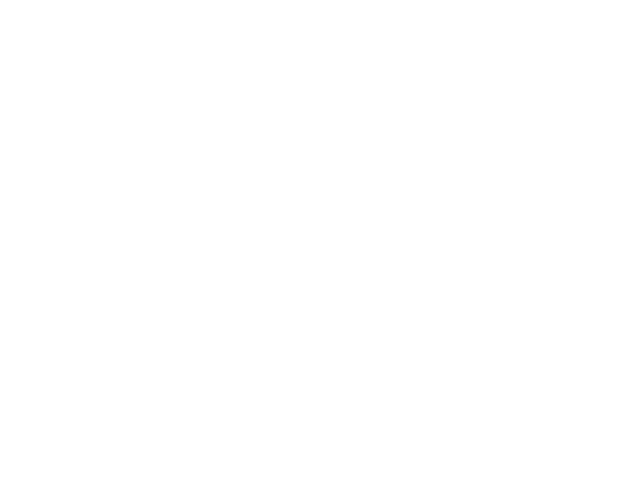

In [12]:
corr_mat = X_train.corr()
plt.figure()
sns.heatmap(corr_mat, cmap = 'magma')

## 4. FEATURE ENGINEERING

In [13]:
#univariate feature selection
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
#transform training
X_train_selected = select.transform(X_train)

/anaconda2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


In [14]:
mask = select.get_support()
print(mask)

[ True  True False  True  True  True  True False  True False False  True
  True  True  True  True False False  True False  True  True  True  True
 False False False False  True False  True False  True False  True False
 False False False False False  True False False False False  True False
  True False False  True False False  True  True False  True False  True
 False False  True  True  True  True  True  True False  True False False
  True  True  True  True False False False False False  True False  True]


Text(0.5,0,u'Sample index')

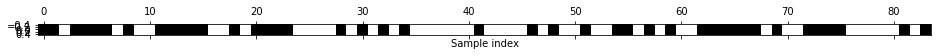

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
#black is true 
plt.matshow(mask.reshape(1, -1), cmap = 'gray_r')
plt.xlabel('Sample index')

## This is the list of significant features listed:
'game_id','sr_start',
'sr_finish','sr_change',
'streak_number',
'my_team_sr','enemy_team_sr',
'capscore','eliminations',
'objective_kills',
'healing','deaths',
'weapon_accuracy',
'Eichenwalde',
'Gibraltar','Hanamura',
'Horizon','lijiang Tower',
'Numbani','Route 66',
'Volskaya Industries',
'1_Ana','1_Orisa',
'1_Rienhart','1_Symmetra',
'1_Zarya','1_Zenyatta',
'1_torbjorn','2_Ana',
'2_Lucio','2_Mercy',
'2_Moira','2_Orisa',
'2_Pharah','2_Zarya',
'2_Zenyatta','2_na',
'3_Ana','3_Lucio',
'3_Zenyatta','3_na'

In [16]:
features = ['game_id','sr_start', 'sr_finish','sr_change', 
            'streak_number', 'my_team_sr','enemy_team_sr', 'capscore','eliminations', 'objective_kills', 'healing','deaths', 'weapon_accuracy', 'Eichenwalde', 'Gibraltar','Hanamura', 'Horizon','lijiang Tower', 'Numbani','Route 66', 'Volskaya Industries', '1_Ana','1_Orisa', '1_Rienhart','1_Symmetra', '1_Zarya','1_Zenyatta', '1_torbjorn','2_Ana', '2_Lucio','2_Mercy', '2_Moira','2_Orisa', '2_Pharah','2_Zarya', '2_Zenyatta','2_na', '3_Ana','3_Lucio', '3_Zenyatta','3_na']

## 5. MODELING

In [17]:
### 1. Create your target (y) variable and your feature matrix (X)
X = ow_dummy[features]
y = ow_dummy['W']

In [18]:
#Scaling
from sklearn.preprocessing import MinMaxScaler
X_test.fillna(0,inplace=True)
scaler = MinMaxScaler()
scaler.fit(X_test)
#X_train = pd.DataFrame(scaler.fit_transform(X_train))

#ONLY transform the test, NOT the train.
X_test = scaler.transform(X_test)

In [19]:
## Let's use the following classification models:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsClassifier

In [20]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## 6. MODEL FIT

Logistic Regression Model Accuracy

In [42]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.86
Accuracy of Logistic regression classifier on test set: 0.88


Random Forest Model Accuracy

In [23]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier().fit(X_train, y_train)
print('Accuracy of Random Forest classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Random Forest classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Random Forest classifier on training set: 1.00
Accuracy of Random Forest classifier on test set: 1.00


K Nearest Neighbors Model Accuracy

In [35]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.84
Accuracy of K-NN classifier on test set: 0.52


## Logistic Regression is most accurate model that we tried. Let's further interpret this model

## 7. SCORING AND INTEPRETING

<b>Reviewing classification scores to understand model fit</b>

In [80]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, r2_score, roc_auc_score, auc
from sklearn.metrics import log_loss, hinge_loss, hamming_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve


pred = logreg.predict(X_test)

print(classification_report(y_test, pred))


             precision    recall  f1-score   support

          0       0.80      1.00      0.89       142
          1       1.00      0.76      0.87       152

avg / total       0.90      0.88      0.88       294



In [37]:
#Confusion Matrix
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,142,0,142
1,36,116,152
All,178,116,294


In [60]:
print(r2_score(y_test,pred))

0.5096367679762788


In [61]:
print(roc_auc_score(y_test,pred))

0.881578947368421


In [74]:
print(log_loss(y_test,pred))

4.229237925907432


In [64]:
print(hamming_loss(y_test,pred))

0.12244897959183673


In [63]:
print(hinge_loss(y_test,pred))

0.6054421768707483


In [69]:
print(roc_auc_score(y_test,pred))

0.881578947368421


In [81]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

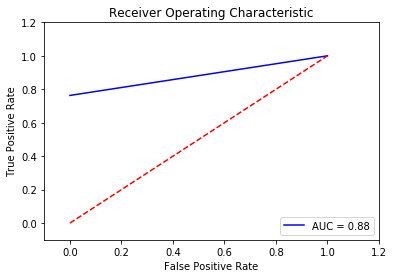

In [82]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## 8. RUN MODEL ON ENTIRE DATASET

**When should you bring in the test set?**
- Only when you're confident of your model i.e. your scores are consistent
- Score your test set, get the predictions, plot residuals or create confusion matrix
- **Remember that ANYTHING YOU DO TO YOUR TRAIN DATA, YOU WILL HAVE TO DO TO YOUR TEST DATA!!!**

In [27]:
#Fill X and y with median
X.fillna(ow.median(),inplace=True)

In [28]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X,y)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X,y)))

Accuracy of Logistic regression classifier on training set: 0.81


In [29]:
features

['game_id',
 'sr_start',
 'sr_finish',
 'sr_change',
 'streak_number',
 'my_team_sr',
 'enemy_team_sr',
 'capscore',
 'eliminations',
 'objective_kills',
 'healing',
 'deaths',
 'weapon_accuracy',
 'Eichenwalde',
 'Gibraltar',
 'Hanamura',
 'Horizon',
 'lijiang Tower',
 'Numbani',
 'Route 66',
 'Volskaya Industries',
 '1_Ana',
 '1_Orisa',
 '1_Rienhart',
 '1_Symmetra',
 '1_Zarya',
 '1_Zenyatta',
 '1_torbjorn',
 '2_Ana',
 '2_Lucio',
 '2_Mercy',
 '2_Moira',
 '2_Orisa',
 '2_Pharah',
 '2_Zarya',
 '2_Zenyatta',
 '2_na',
 '3_Ana',
 '3_Lucio',
 '3_Zenyatta',
 '3_na']